In [1]:
%%javascript
$('<div id="toc"></div>').css({position: 'fixed', top: '120px', left: 0}).appendTo(document.body);
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js');

<IPython.core.display.Javascript object>

# Libraries

In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np

from jupyterthemes import jtplot
jtplot.style()

import xgboost as xg
from xgboost import XGBModel
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import RFE

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from sklearn.preprocessing import LabelEncoder
from sklearn import cross_validation

from catboost import CatBoostRegressor
from tqdm import tqdm

%matplotlib inline
%load_ext autotime
%load_ext line_profiler
%matplotlib inline 

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module '_catboost' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
def plot_best_features(model, data, num_features, figsize=(4,10)):
    """ 
    Plot best features. 
    
    Args:
        model (XGBRegressor) : The best XGBRegressor estimator from GridSearchCV or other 
                               model of type XGBRegressor.
        data     (DataFrame) : Data containing all features and column names.
        
    Returns:
        dict : The newly created dictionary, which maps 'data' features to their associated score.
        
    """
    
    new_scores = {}
    # Get the XGB Model's score and assign values and keys to the new dictionary
    scores = model.get_score(importance_type='weight')
    for i in scores.keys():
        new_scores[data.columns[int(i[1:])]] = scores[i]
    # Build a dataframe with the top 'num_features'
    df_features = pd.DataFrame.from_records([new_scores], index=['Features']).T.sort_values('Features').tail(num_features)
    # Plot feature significance based on the models' score
    df_features.plot.barh(figsize=figsize)
    
    return new_scores

time: 7.77 ms


# Data Load

In [4]:
# Load data
transactions = pd.read_csv('../Data/properties_2016.csv', low_memory=False)
# Load train data
train_data = pd.read_csv('../Data/train_2016_v2.csv')
# Elements to be forecasted - this is the framework
submission_sample = pd.read_csv('../Data/sample_submission.csv')
# Load label description and feature documentation
label_documentation = pd.read_csv('../Data/zillow_data_dictionary.csv', encoding='ISO8859_1')

duplicate_records = train_data[train_data['parcelid'].duplicated()]['parcelid'].unique()

time: 29.8 s


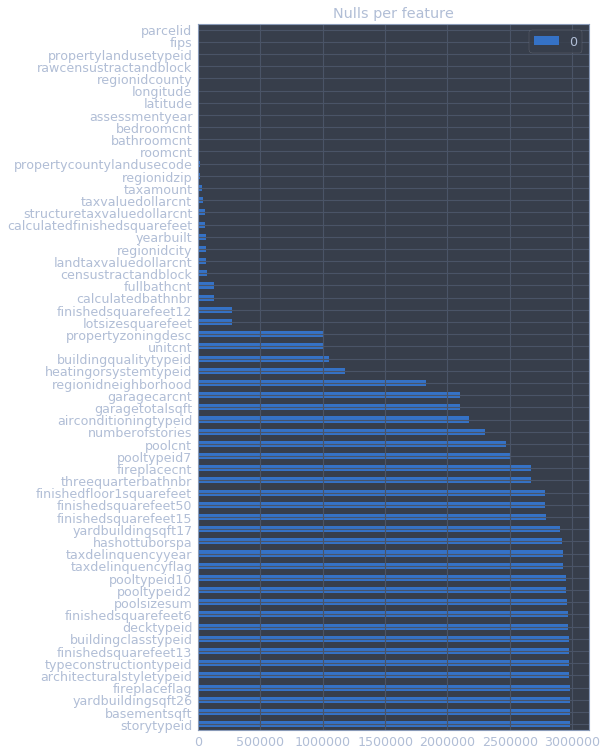

time: 4.26 s


In [5]:
# Show how many nulls there are for each feature
nulls = transactions.isnull().sum().sort_values(ascending=False).to_frame()
null_features = list(nulls[nulls[0] > 1200000].index) # Features which should be dropped due to having many nulls.
nulls.plot.barh(figsize=(7,13), title='Nulls per feature')

# Visualisation

/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


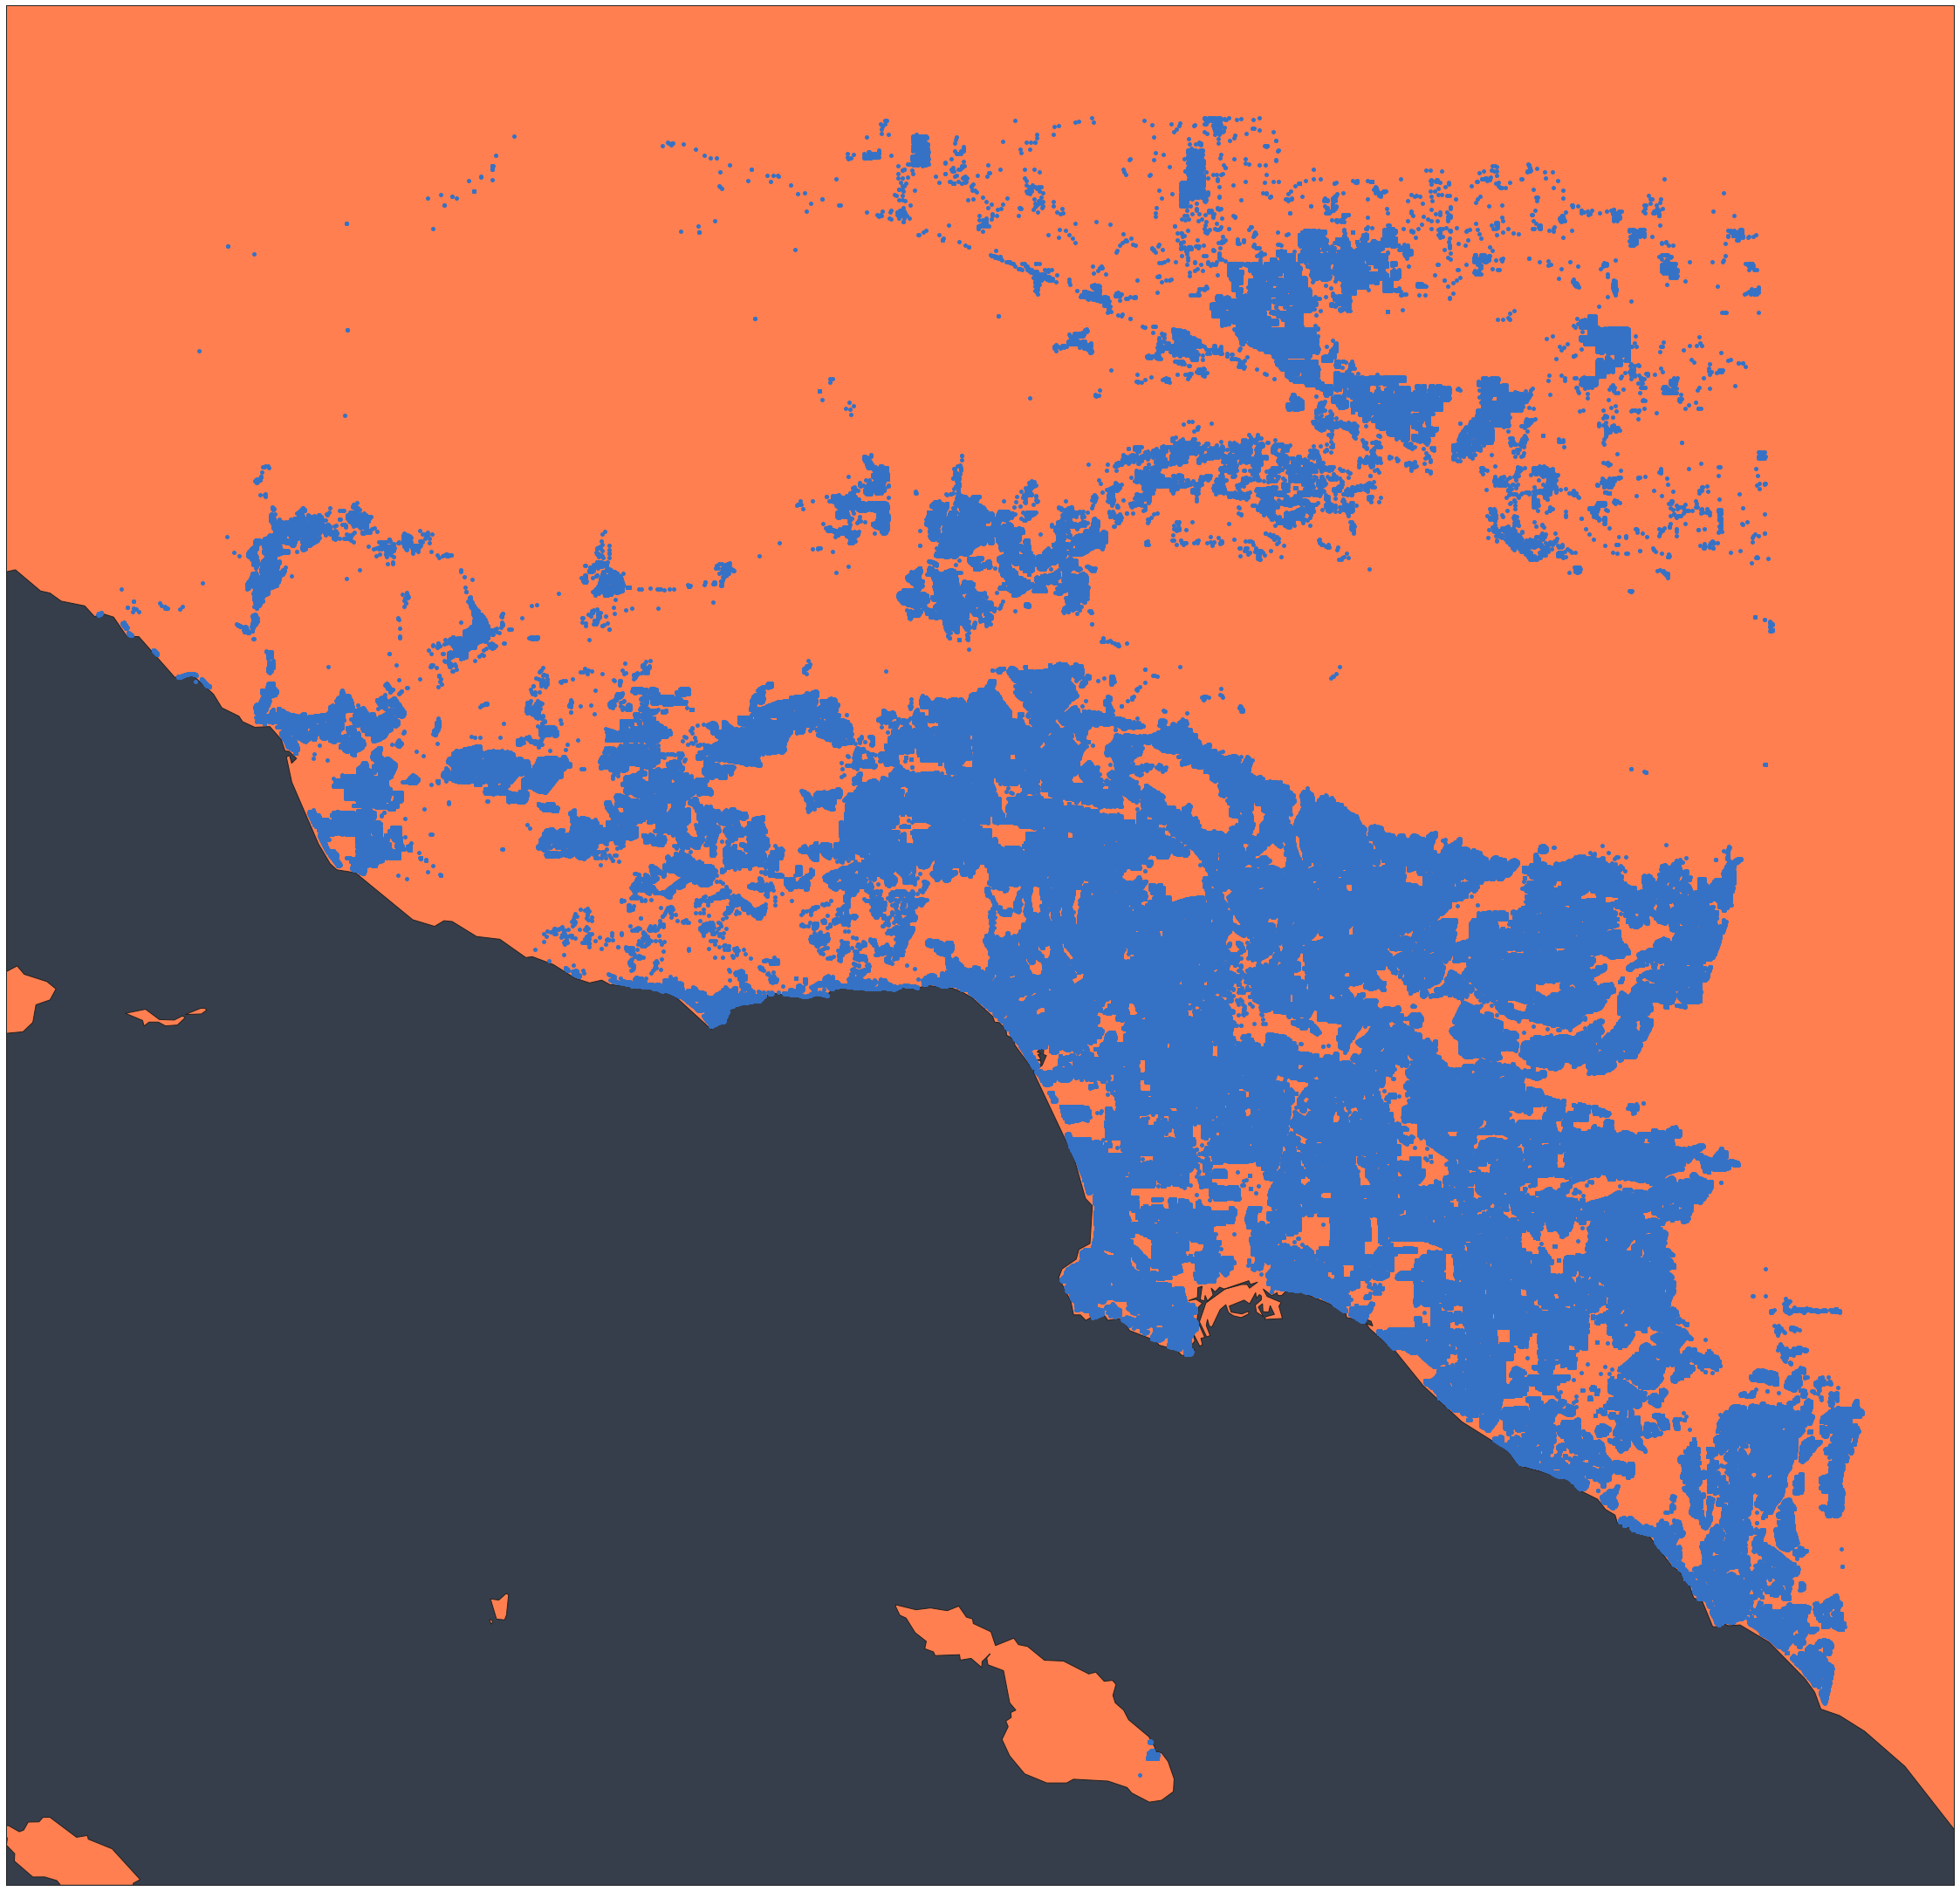

time: 26.6 s


In [6]:
transactions['latitude'] = transactions['latitude']/1000000
transactions['longitude'] = transactions['longitude']/1000000

# Get latitude and longitude extremes
min_lat = transactions['latitude'].min()
max_lat = transactions['latitude'].max()
min_lon = transactions['longitude'].min()
max_lon = transactions['longitude'].max()

# Build map
area = 0.1
fig = plt.figure(figsize=(40,40))
map = Basemap(projection='merc', lat_0 = np.mean([min_lat, max_lat]), lon_0 = np.mean([min_lon, max_lon]),
    resolution = 'h', area_thresh = 0.1,
    llcrnrlon=min_lon - area, llcrnrlat=min_lat - area,
    urcrnrlon=max_lon + area, urcrnrlat=max_lat + area)
 
map.drawcoastlines()
map.drawcountries()
map.fillcontinents(color = 'coral')
map.drawmapboundary()
 
lon = transactions['longitude'].values
lat = transactions['latitude'].values
x,y = map(lon, lat)
map.plot(x, y, 'bo', markersize=5)

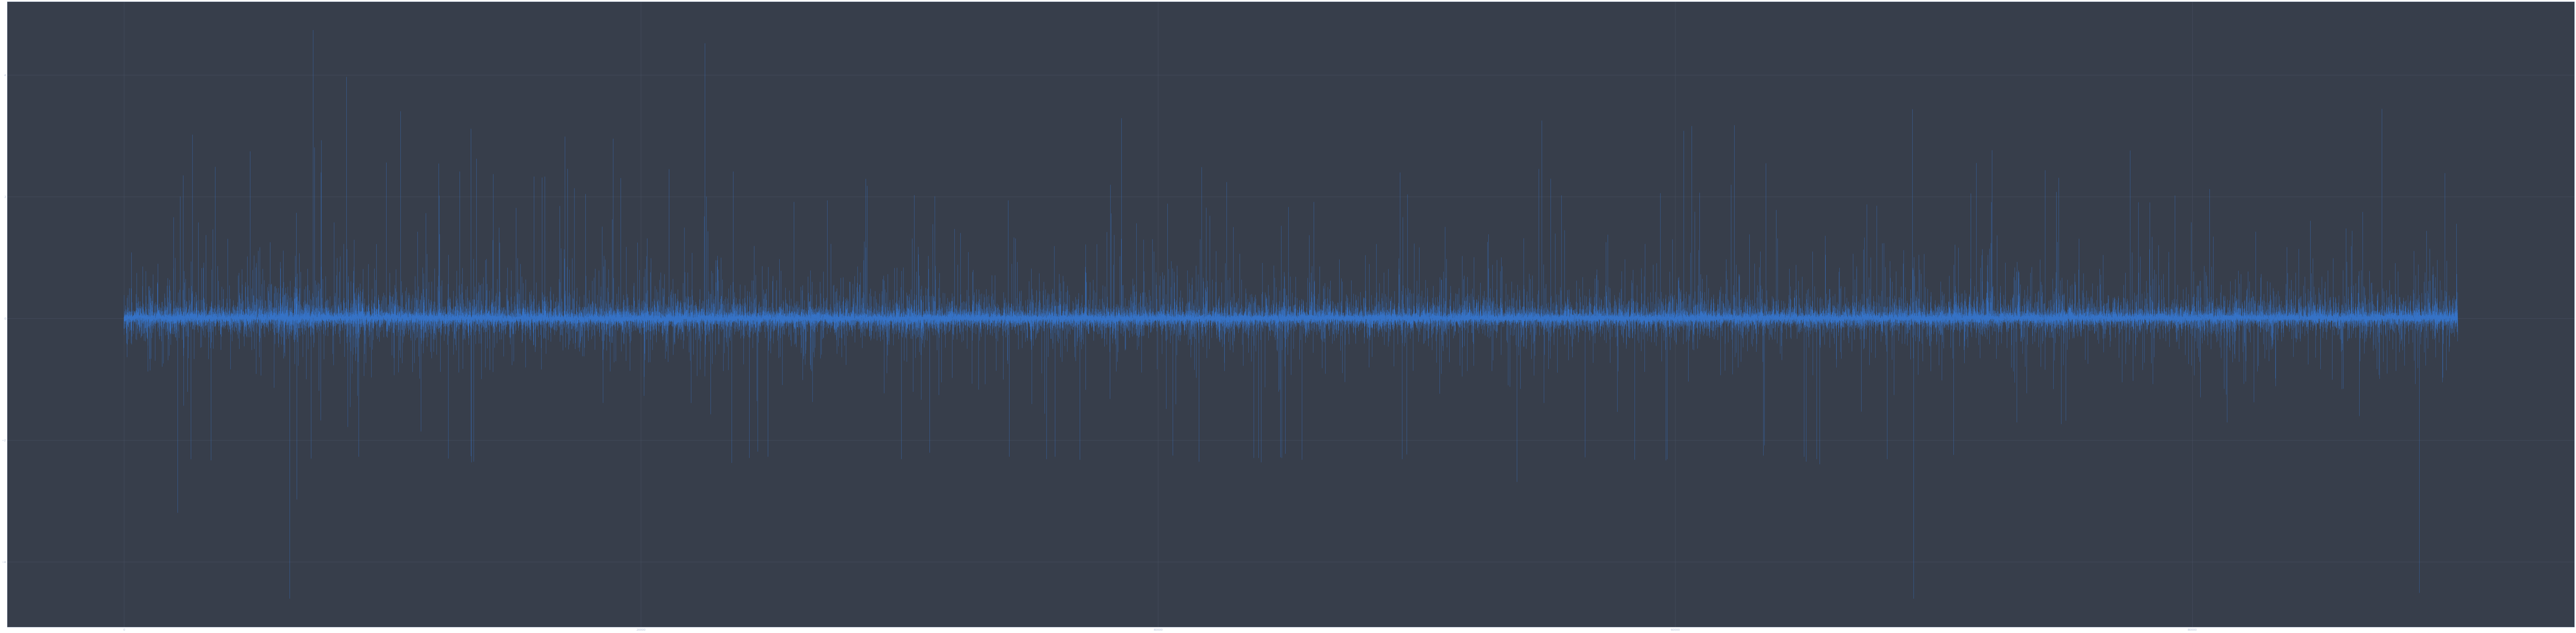

time: 11.2 s


In [7]:
fig = plt.figure(figsize=(200,50))
plt.plot(train_data['logerror'], linewidth=0.5)

In [8]:
label_documentation

,Feature,Description
0,'airconditioningtypeid',Type of cooling system present in the home (i...
1,'architecturalstyletypeid',"Architectural style of the home (i.e. ranch, ..."
2,'basementsqft',Finished living area below or partially below...
3,'bathroomcnt',Number of bathrooms in home including fractio...
4,'bedroomcnt',Number of bedrooms in home
5,'buildingqualitytypeid',Overall assessment of condition of the buildi...
6,'buildingclasstypeid',"The building framing type (steel frame, wood f..."
7,'calculatedbathnbr',Number of bathrooms in home including fractio...
8,'decktypeid',Type of deck (if any) present on parcel
9,'threequarterbathnbr',Number of 3/4 bathrooms in house (shower + si...


time: 12.1 ms


# Processing

In [9]:
def plot_data(test, pred, sample, title, width=40, height=10, linewidth=0.5, color1='white', color2='orange'):
    """ Plotting method. """
    fig = plt.figure(figsize=(width, height))
    plt.plot(pred[:sample], color=color1, zorder=4, linewidth=linewidth, label='%s Prediction'%(title))
    plt.plot(test[:sample], color=color2, zorder=3, linewidth=linewidth, label='%s True Data'%(title))
    plt.title = title
    plt.legend()

# Frequency count
def get_frequency(data):
    # Gets the frequency of a column's values in 'data'. Pass on a series.
    vals = pd.merge(data.to_frame(), data.value_counts().reset_index(), 
                    how='left', left_on=data.to_frame().columns[0], right_on='index').iloc[:, -1:].values
    return vals
  
def time_data(data):
    data['transactiondate'] = pd.to_datetime(data['transactiondate'])
    data['day_of_week']     = data['transactiondate'].dt.dayofweek
    data['month_of_year']   = data['transactiondate'].dt.month
    data['quarter']         = data['transactiondate'].dt.quarter
    data['is_weekend']      = (data['day_of_week'] < 5).astype(int)
    data.drop('transactiondate', axis=1, inplace=True)
    
    print('Added time data')
    print('........')
    
    return data


def column_excluder(data, missing_perc_thresh=0.98):
    # Quick clean from https://www.kaggle.com/seesee/concise-catboost-starter-ensemble-plb-0-06435
    
    exclude_missing = []
    exclude_unique = []
    num_rows = data.shape[0]
    for c in data.columns:
        num_missing = data[c].isnull().sum()
        if num_missing == 0:
            continue
        missing_frac = num_missing / float(num_rows)
        if missing_frac > missing_perc_thresh:
            exclude_missing.append(c)

        num_uniques = len(data[c].unique())
        if data[c].isnull().sum() != 0:
            num_uniques -= 1
        if num_uniques == 1:
            exclude_unique.append(c)
            
    to_exclude = list(set(exclude_missing + exclude_unique))
    
    print('Excluded columns:')
    print(to_exclude)
    print('........')
    
    return to_exclude

def categorical_features(data):
    # Quick categories from https://www.kaggle.com/seesee/concise-catboost-starter-ensemble-plb-0-06435
        
    cat_feature_inds = []
    cat_unique_thresh = 1000
    for i, c in enumerate(data.columns):
        num_uniques = len(data[c].unique())
        if num_uniques < cat_unique_thresh \
            and not 'sqft'   in c \
            and not 'cnt'    in c \
            and not 'nbr'    in c \
            and not 'number' in c:
            cat_feature_inds.append(i)

    print("Categorical features:")
    print([data.columns[ind] for ind in cat_feature_inds])
    print('........')
    
    return cat_feature_inds


def complex_features(data):
    # Gets counts, label encoding and frequency estimates.
    
    # Frequency of occurances | length of codes | check if * is present
    data['propertyzoningdesc_frq'] = get_frequency(data['propertyzoningdesc'])
    data['propertyzoningdesc_len'] = data['propertyzoningdesc'].apply(lambda x: len(x) if pd.notnull(x) else x)
    #transactions_shuffled['propertyzoningdesc_str'] = transactions_shuffled['propertyzoningdesc'].apply(lambda x: (1 if '*' in str(x) else 0) if pd.notnull(x) else x)

    # Label encoding | length of code
    #transactions_shuffled['propertycountylandusecode_enc'] = transactions_shuffled[['propertycountylandusecode']].astype(str).apply(LabelEncoder().fit_transform)
    #transactions_shuffled['propertycountylandusecode_len'] = transactions_shuffled['propertycountylandusecode'].apply(lambda x: x if pd.isnull(x) else len(x))

    # Zip code area extraction
    data['regionidzip_ab']  = data['regionidzip'].apply(lambda x: x if pd.isnull(x) else str(x)[:2])
    data['regionidzip_abc'] = data['regionidzip'].apply(lambda x: x if pd.isnull(x) else str(x)[:3])

    # Region neighbourhood area extraction
    data['regionidneighborhood_ab'] = data['regionidneighborhood'].apply(lambda x: str(x)[:2] if pd.notnull(x) else x)

    # Rawcensustractandblock transformed
    data['code_fips_cnt']  = get_frequency(data['rawcensustractandblock'].apply(lambda x: str(x)[:4]))
    data['code_tract_cnt'] = get_frequency(data['rawcensustractandblock'].apply(lambda x: str(x)[4:11]))
    data['code_block_cnt'] = get_frequency(data['rawcensustractandblock'].apply(lambda x: str(x)[11:]))
    
    
    data.drop(['rawcensustractandblock', 'propertyzoningdesc'], axis=1, inplace=True)
    
    print('Generating complex features')
    print('........')
    
    return data

time: 133 ms


In [12]:
# RAW DATA FEATURES
transactions = pd.read_csv('../Data/properties_2016.csv', low_memory=False)

transactions_shuffled = pd.merge(train_data, transactions, how='left', on=['parcelid']).sample(frac=1)
# Drop outliers 
transactions_shuffled = transactions_shuffled[(transactions_shuffled['logerror'] > -0.4) & (transactions_shuffled['logerror'] < 0.419)]

# Clean columns
to_drop = column_excluder(transactions_shuffled)
transactions_shuffled.drop(to_drop, axis=1, inplace=True)
# Time data
transactions_shuffled = time_data(transactions_shuffled)

index_categories = categorical_features(transactions_shuffled)

transactions_shuffled = complex_features(transactions_shuffled)

##############
# TRAIN DATA #
##############

y_all = transactions_shuffled['logerror']
x_all = transactions_shuffled.drop(['parcelid', 'logerror'], axis=1)

print('Train features:')
print(x_all.columns)
print('........')

x_all = x_all.fillna(-999)#.astype(str).apply(LabelEncoder().fit_transform)

ratio = 0.1

best_columns = x_all.columns
x_train, x_valid, y_train, y_valid = train_test_split(x_all, y_all, test_size=ratio, random_state=69)
y_mean = np.mean(y_train)

del x_all
del y_all
#del transactions_shuffled

Excluded columns:
['taxdelinquencyyear', 'decktypeid', 'buildingclasstypeid', 'poolcnt', 'architecturalstyletypeid', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'storytypeid', 'fireplaceflag', 'finishedsquarefeet13', 'yardbuildingsqft26', 'finishedsquarefeet6', 'basementsqft', 'taxdelinquencyflag', 'typeconstructiontypeid', 'hashottuborspa', 'pooltypeid7']
........
Added time data
........
Categorical features:
['logerror', 'airconditioningtypeid', 'buildingqualitytypeid', 'fips', 'heatingorsystemtypeid', 'propertycountylandusecode', 'propertylandusetypeid', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'yearbuilt', 'assessmentyear', 'day_of_week', 'month_of_year', 'quarter', 'is_weekend']
........
Generating complex features
........
Train features:
Index(['airconditioningtypeid', 'bathroomcnt', 'bedroomcnt',
       'buildingqualitytypeid', 'calculatedbathnbr',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12'

In [ ]:
transactions_shuffled

# Cat Boost

In [11]:
def cat_booster(x_train, y_train, x_valid):
    # Cat booster train and predict
    num_ensembles = 5
    y_pred_valid = 0.0
    y_pred_train = 0.0
    
    for i in tqdm(range(num_ensembles)):
        # Use CV, tune hyperparameters
        catb = CatBoostRegressor(
            iterations=200, learning_rate=0.03,
            depth=3, l2_leaf_reg=3,
            loss_function='MAE',
            eval_metric='MAE',
            random_seed=i)

        catb.fit(x_train, y_train, cat_features=index_categories)

        y_pred_valid += catb.predict(x_valid)
        y_pred_train += catb.predict(x_train)

    y_pred_valid /= num_ensembles
    y_pred_train /= num_ensembles

    print('Train MAE:', mean_absolute_error(y_train, y_pred_train))
    #print('Valid MAE:', mean_absolute_error(y_valid, y_pred_valid))
    
    return y_pred_valid
    
cat_booster(x_train, y_train, x_valid)

  0%|          | 0/5 [00:00<?, ?it/s]


ValueError: could not convert string to float: '010C'

time: 407 ms


In [ ]:
# https://www.kaggle.com/c/zillow-prize-1/discussion/33899, Oct,Nov,Dec
test_dates = {'201610': pd.Timestamp('2016-09-30'),
              '201611': pd.Timestamp('2016-10-31'),
              '201612': pd.Timestamp('2016-11-30')}

x_predict = transactions.copy()
x_predict = complex_features(x_predict)

for m in test_dates.keys():
    print('Processing', m)  
    x_predict['transactiondate'] = test_dates[m]
    x_predict = time_data(x_predict)
    x_predict = x_predict[best_columns].fillna(-999).astype(str).apply(LabelEncoder().fit_transform)
    
    print('Predicting')
    print('........')
    
    # 5 iterations cat booster for each prediction.
    x_predict[m] = cat_booster(x_train, y_train, x_predict.values)
    submission_sample[m] = submission_sample['ParcelId'].to_frame().merge(x_predict[['parcelid', m]], how='left', left_on='ParcelId', right_on='parcelid')[m]
    
del x_predict
del predictions

In [ ]:
x_predict.values.shape

In [ ]:
cat_booster(x_train, y_train, x_predict.values)

In [ ]:
# All scorer objects follow the convention that higher return values are better than lower return 
# values. Thus metrics which measure the distance between the model and the data, like 
# metrics.mean_squared_error, are available as neg_mean_squared_error which return the negated 
# value of the metric.

scores = cross_validation.cross_val_score(catb, x_train, y_train, cv=5, 
                                          scoring='neg_mean_absolute_error', verbose=1)

print("%s Accuracy: %0.5f (+/- %0.5f)" % (catb.__class__.__name__, scores.mean(), scores.std() * 2))

# XGB

In [ ]:
params1={
    'max_depth':        3, # shuld be 0.5 to 1% of the examples
    'subsample':        1,  # Ratio of observations to be used as samples for each tree
    'min_child_weight': 12, # Deals with imbalanced data and prevents overfitting as the value >
    #'gamma':            0.1,
    #'booster':          'gblinear',#'gbtree',
    'objective':        'reg:linear',
    'n_estimators':     1000, # Sequential trees to be modelled.
    'learning_rate':    0.09, # shrinkage
    'scale_pos_weight': 1, # Helps with imbalanced classes and speeds up convergence. 
    'eval_metric':      'mae',
    'base_score':       y_mean,
    #'alpha':            0.4,
    #'lambda':           0.8, # Ridge regression or L2 regularisation - reduces overfitting.
    'seed':             399
}

params2={
    'max_depth':        5, # shuld be 0.5 to 1% of the examples
    'subsample':        0.8,  # Ratio of observations to be used as samples for each tree
    'min_child_weight': 10, # Deals with imbalanced data and prevents overfitting as the value >
    'objective':        'reg:linear',
    'n_estimators':     1000, # Sequential trees to be modelled.
    'eta':              0.033, # Shrinkage. Typically between 0.1 - 0.2 - learning rate for gradient boost (D:0.3)
    'eval_metric':      'mae',
    'base_score':       y_mean,
    'seed':             33
}

d_train = xg.DMatrix(x_train, label=y_train)
d_valid = xg.DMatrix(x_valid, label=y_valid)

# Top :                                       train-mae:0.067973  valid-mae:0.064692
# All fillna 0 + blocks, month, day, quarter: train-mae:0.067896  valid-mae:0.067018
# All nan, blocks:                            train-mae:0.067735  valid-mae:0.068553
# All nan:                                    train-mae:0.06764   valid-mae:0.070151
# Filna 0, Poly2 + RFE 100                    train-mae:0.067816  valid-mae:0.06716
# Label encoding                              train-mae:0.067815  valid-mae:0.068403

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
xgb_gs1 = xg.train(params1, d_train, len(x_valid), watchlist, early_stopping_rounds=250, verbose_eval=10)
xgb_gs2 = xg.train(params2, d_train, len(x_valid), watchlist, early_stopping_rounds=150, verbose_eval=10)

#best_f = plot_best_features(xgb_gs1, x_all, 100)
del d_train
del d_valid

In [ ]:
# STACKING XGB
xgb_pred = XGB1_WEIGHT*xgb_pred1 + (1-XGB1_WEIGHT)*xgb_pred2

In [ ]:
# https://www.kaggle.com/c/zillow-prize-1/discussion/33899, Oct,Nov,Dec
test_dates = {
    '201610': pd.Timestamp('2016-09-30'),
    '201611': pd.Timestamp('2016-10-31'),
    '201612': pd.Timestamp('2016-11-30'),
#    '201710': pd.Timestamp('2017-09-30'),
#   '201711': pd.Timestamp('2017-10-31'),
#    '201712': pd.Timestamp('2017-11-30')
}

all_preds = pd.DataFrame()
for m in test_dates.keys():
    # Building predictions.
    print('Processing', m)
    x_predict = transactions.copy()
    x_predict = complex_features(x_predict)
    x_predict['transactiondate'] = test_dates[m]
    x_predict = time_data(x_predict)
    
    print('Cleaning data')
    print('........')
    
    x_predict = x_predict.fillna(-999).astype(str).apply(LabelEncoder().fit_transform)
    
    print('Predicting')
    print('........')
    
    x_predict[m] = xgb_gs2.predict(xg.DMatrix(x_predict[best_columns]))
    all_preds[m] = x_predict[m].copy()
    submission_sample[m] = submission_sample['ParcelId'].to_frame().merge(x_predict[['parcelid', m]], how='left', left_on='ParcelId', right_on='parcelid')[m]
    
#del x_predict

In [ ]:
x_predict = transactions.copy()

In [ ]:
submission_sample[m] = submission_sample['ParcelId'].to_frame().merge(x_predict[['parcelid', m]], how='left', left_on='ParcelId', right_on='parcelid')[m]

In [ ]:
x_predict[list(test_dates.keys())] = all_preds[list(test_dates.keys())]

In [ ]:
x_predict

In [ ]:
m = '201610'
submission_sample[m] = submission_sample['ParcelId'].to_frame().merge(x_predict[['parcelid', m]], how='left', left_on='ParcelId', right_on='parcelid')[m]

In [ ]:
submission_sample

In [ ]:
submission_sample.to_csv('submission4.csv',index=False)
submission_sample.head()

# RFE